# Predikcija proizvodnje i potrošnje električne energije na osnovu vremenskih uslova i doba dana

## Uvod

U ovom notebook-u biće kreirani modeli za prediciju potrošnje i proizvodnje električne energije iz obnovljivih izovra.

## Priprema podataka

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb

Prikaz podataka iz weather_features data set-a koji sadrži podatke o vremenskim uslovima u 5 najvećih gradaova u Španiji (Madrid, Valensija, Bilbao, Barselona, Sevilja) u periodu od 1.1.2015 do 31.12.2018. u intervalima od sat.

In [2]:
df = pd.read_csv("weather_features.csv")
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_main', 'weather_description', 'weather_id', 'humidity', 'pressure', 'temp']].copy()
df

,dt_iso,city_name,wind_speed,wind_deg,clouds_all,weather_main,weather_description,weather_id,humidity,pressure,temp
0,2015-01-01 00:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001,270.475
1,2015-01-01 01:00:00+01:00,Valencia,1,62,0,clear,sky is clear,800,77,1001,270.475
2,2015-01-01 02:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
3,2015-01-01 03:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
4,2015-01-01 04:00:00+01:00,Valencia,0,23,0,clear,sky is clear,800,78,1002,269.686
...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,54,1028,287.760
178392,2018-12-31 20:00:00+01:00,Seville,3,30,0,clear,sky is clear,800,62,1029,285.760
178393,2018-12-31 21:00:00+01:00,Seville,4,50,0,clear,sky is clear,800,58,1028,285.150
178394,2018-12-31 22:00:00+01:00,Seville,4,60,0,clear,sky is clear,800,57,1029,284.150


In [3]:
print(df.columns[df.isnull().any()])

Index([], dtype='str')


Prikaz podataka iz energy_dataset data set-a koji sadrži podatke o proizvodnji i potrošnji električne energije u periodu od 1.1.2015 do 31.12.2018. u intervalima od sat.

In [4]:
df_energy = pd.read_csv("energy_dataset.csv")
df_energy = df_energy[['time', 'generation solar', 'generation wind onshore', 'total load actual']].copy()
df_energy

,time,generation solar,generation wind onshore,total load actual
0,2015-01-01 00:00:00+01:00,49.0,6378.0,25385.0
1,2015-01-01 01:00:00+01:00,50.0,5890.0,24382.0
2,2015-01-01 02:00:00+01:00,50.0,5461.0,22734.0
3,2015-01-01 03:00:00+01:00,50.0,5238.0,21286.0
4,2015-01-01 04:00:00+01:00,42.0,4935.0,20264.0
...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,85.0,3113.0,30653.0
35060,2018-12-31 20:00:00+01:00,33.0,3288.0,29735.0
35061,2018-12-31 21:00:00+01:00,31.0,3503.0,28071.0
35062,2018-12-31 22:00:00+01:00,31.0,3586.0,25801.0


In [5]:
print(df_energy.columns[df_energy.isnull().any()])

Index(['generation solar', 'generation wind onshore', 'total load actual'], dtype='str')


Sredjivanje nedostajućih vrednosti.

In [6]:
total_rows = len(df_energy)
missing_percentage = (df_energy.isnull().sum() / total_rows) * 100

print("\nProcenat nedostajućih vrednosti:")
print(missing_percentage[missing_percentage > 0].round(2).astype(str) + '%')

df_energy['generation solar'] = df_energy['generation solar'].ffill()
df_energy['generation wind onshore'] = df_energy['generation wind onshore'].ffill()
df_energy['total load actual'] = df_energy['total load actual'].ffill()




Procenat nedostajućih vrednosti:
generation solar           0.05%
generation wind onshore    0.05%
total load actual           0.1%
dtype: str


Kreiranje finalnog skupa podataka

Moramo osigurati da oba DataFrame-a imaju isto ime kolone za vreme

In [7]:
df_energy = df_energy.rename(columns={'time': 'dt_iso'})

df_energy['dt_iso'] = pd.to_datetime(df_energy['dt_iso'], utc=True)
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True)

Da bismo imali jedan red po satu, moramo raširiti gradove u kolone. Tako ćemo u jednom redu imati temperaturu i vetar za Madrid, Bilbao, Sevilju, Barselonu i Valensiju. Za neke gradove su postojali duplikati vremenskih zapisa za isti sat, pa je bilo potrebno izbrisati duplikate.

In [8]:
df = df[['dt_iso', 'city_name', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'humidity', 'pressure', 'temp']].copy()

df = df.drop_duplicates(subset=['dt_iso', 'city_name'])

df['city_name'] = df['city_name'].str.strip()
df_weather_wide = df.pivot(index='dt_iso', columns='city_name')

df_weather_wide.columns = [f'{col[0]}_{col[1]}' for col in df_weather_wide.columns]
df_weather_wide = df_weather_wide.reset_index()

df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

In [9]:
df_final = pd.merge(df_weather_wide, df_energy, on='dt_iso', how='inner')

print(f"Dimenzije spojenog fajla: {df_final.shape}")

print(df_final.columns.tolist())

Dimenzije spojenog fajla: (35064, 39)
['dt_iso', 'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia', 'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia', 'clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia', 'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia', 'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia', 'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia', 'temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia', 'generation solar', 'generation wind onshore', 'total load actual']


Nakon što smo kreirali finalni skup podataka koji sadrži sva polja od značaja prelazimo na keiranje modela.

## Proizvodnja solarnih elektrana

U ovom poglavlju kriraćemo dva modela za predkiciju proizvodnje električne energije dobijene iz solarnih elektrana

### Random Forrest

In [10]:
df_final['hour'] = df_final['dt_iso'].dt.hour
df_final['month'] = df_final['dt_iso'].dt.month
df_final['day_of_week'] = df_final['dt_iso'].dt.dayofweek

features_solar = [
    'hour', 'month', 'day_of_week',

    'clouds_all_Barcelona', 'clouds_all_Bilbao', 'clouds_all_Madrid', 'clouds_all_Seville', 'clouds_all_Valencia',
    
    'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia',

    'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia',

    'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia'
]

X = df_final[features_solar]
y_solar = df_final['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_solar.fit(X_train, y_train)

y_pred = rf_solar.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} MW")

importances = rf_solar.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_solar, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

R2 Score: 0.8266
MAE: 437.37 MW
                 Feature  Importance
0                   hour    0.670506
20       humidity_Madrid    0.076395
22     humidity_Valencia    0.036155
21      humidity_Seville    0.028633
1                  month    0.027287
18    humidity_Barcelona    0.017910
14       pressure_Bilbao    0.015534
19       humidity_Bilbao    0.015448
16      pressure_Seville    0.014331
13    pressure_Barcelona    0.011479
17     pressure_Valencia    0.011049
15       pressure_Madrid    0.010777
2            day_of_week    0.009700
4      clouds_all_Bilbao    0.006887
5      clouds_all_Madrid    0.006761
9      weather_id_Bilbao    0.006595
3   clouds_all_Barcelona    0.005978
8   weather_id_Barcelona    0.005784
6     clouds_all_Seville    0.005594
11    weather_id_Seville    0.005036
7    clouds_all_Valencia    0.004582
10     weather_id_Madrid    0.004061
12   weather_id_Valencia    0.003518


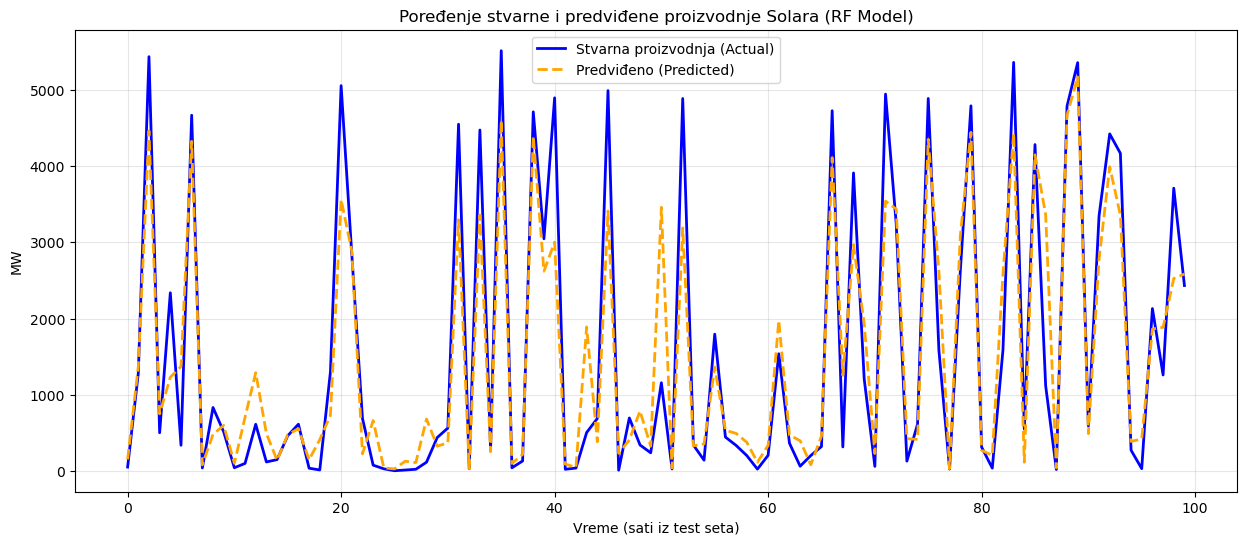

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Stvarna proizvodnja (Actual)', color='blue', linewidth=2)
plt.plot(y_pred[:100], label='Predviđeno (Predicted)', color='orange', linestyle='--', linewidth=2)

plt.title('Poređenje stvarne i predviđene proizvodnje Solara (RF Model)')
plt.xlabel('Vreme (sati iz test seta)')
plt.ylabel('MW')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### XGBoost

In [13]:
xgb_solar = xgb.XGBRegressor(
    n_estimators=500,       
    learning_rate=0.05,    
    max_depth=7,         
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42,
    n_jobs=-1
)

X = df_final[features_solar]
y_solar = df_final['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

xgb_solar.fit(X_train, y_train)

y_pred_xgb = xgb_solar.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)

print("--- XGBoost Rezultati Solar ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

xgb_importances = pd.DataFrame({
    'Feature': features_solar, 
    'Importance': xgb_solar.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importances)

--- XGBoost Rezultati Solar ---
R2 Score: 0.8871
MAE: 360.50 MW
RMSE: 565.42 MW

XGBoost Feature Importance:
                 Feature  Importance
0                   hour    0.426531
22     humidity_Valencia    0.077777
20       humidity_Madrid    0.068687
21      humidity_Seville    0.046750
5      clouds_all_Madrid    0.034618
1                  month    0.034379
6     clouds_all_Seville    0.027795
18    humidity_Barcelona    0.025678
19       humidity_Bilbao    0.022874
7    clouds_all_Valencia    0.021629
16      pressure_Seville    0.020299
17     pressure_Valencia    0.019967
11    weather_id_Seville    0.019540
15       pressure_Madrid    0.018690
14       pressure_Bilbao    0.017913
13    pressure_Barcelona    0.017413
8   weather_id_Barcelona    0.016121
3   clouds_all_Barcelona    0.015692
10     weather_id_Madrid    0.014780
12   weather_id_Valencia    0.014205
2            day_of_week    0.014129
4      clouds_all_Bilbao    0.012781
9      weather_id_Bilbao    0.011753


## Proizvodnja vetroelektrana

U ovom poglavlju kriraćemo dva modela za predkiciju proizvodnje električne energije dobijene iz vetroelektrana

### Random Forrest

In [14]:
df_final['hour'] = df_final['dt_iso'].dt.hour
df_final['month'] = df_final['dt_iso'].dt.month
df_final['day_of_week'] = df_final['dt_iso'].dt.dayofweek

features_wind = [
    'hour', 'month', 'day_of_week',

    'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia',

    'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia',

    'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia',

    'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia',

    'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia'
]

X = df_final[features_wind]
y_solar = df_final['generation wind onshore']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_solar.fit(X_train, y_train)

y_pred = rf_solar.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} MW")

importances = rf_solar.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features_wind, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

R2 Score: 0.6104
MAE: 1508.71 MW
                 Feature  Importance
5      wind_speed_Madrid    0.089889
19       pressure_Bilbao    0.069572
1                  month    0.064036
21      pressure_Seville    0.056046
18    pressure_Barcelona    0.052669
27     humidity_Valencia    0.045263
25       humidity_Madrid    0.042094
22     pressure_Valencia    0.040556
20       pressure_Madrid    0.040324
2            day_of_week    0.037693
14       wind_deg_Bilbao    0.035179
26      humidity_Seville    0.034310
17     wind_deg_Valencia    0.034067
23    humidity_Barcelona    0.033575
24       humidity_Bilbao    0.032807
16      wind_deg_Seville    0.029847
13    wind_deg_Barcelona    0.029290
0                   hour    0.029043
15       wind_deg_Madrid    0.028535
7    wind_speed_Valencia    0.028035
4      wind_speed_Bilbao    0.026751
9      weather_id_Bilbao    0.021448
3   wind_speed_Barcelona    0.020642
6     wind_speed_Seville    0.018589
8   weather_id_Barcelona    0.017648
11   

### XGBoost

In [15]:

xgb_solar = xgb.XGBRegressor(
    n_estimators=500,       
    learning_rate=0.05,    
    max_depth=7,            
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42,
    n_jobs=-1
)

X = df_final[features_wind]
y_solar = df_final['generation wind onshore']

X_train, X_test, y_train, y_test = train_test_split(X, y_solar, test_size=0.2, random_state=42)

rf_solar = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

xgb_solar.fit(X_train, y_train)

y_pred_xgb = xgb_solar.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse) 

print("--- XGBoost Rezultati Wind ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

xgb_importances = pd.DataFrame({
    'Feature': features_wind, 
    'Importance': xgb_solar.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importances)

--- XGBoost Rezultati Wind ---
R2 Score: 0.6445
MAE: 1430.42 MW
RMSE: 1937.46 MW

XGBoost Feature Importance:
                 Feature  Importance
5      wind_speed_Madrid    0.142052
7    wind_speed_Valencia    0.056945
19       pressure_Bilbao    0.050946
1                  month    0.047951
18    pressure_Barcelona    0.045795
22     pressure_Valencia    0.045784
4      wind_speed_Bilbao    0.045746
21      pressure_Seville    0.042832
20       pressure_Madrid    0.039347
17     wind_deg_Valencia    0.034030
27     humidity_Valencia    0.033062
2            day_of_week    0.030557
9      weather_id_Bilbao    0.030220
25       humidity_Madrid    0.029737
14       wind_deg_Bilbao    0.027262
8   weather_id_Barcelona    0.026297
10     weather_id_Madrid    0.025958
23    humidity_Barcelona    0.025944
12   weather_id_Valencia    0.024687
24       humidity_Bilbao    0.024650
6     wind_speed_Seville    0.024257
26      humidity_Seville    0.023757
11    weather_id_Seville    0.022778
15

## Potrošnja električne energije

U ovom poglavlju kreiraćemo dva modela za predikciju potrošnje električne energije u Španiji.

### Random Forrest

In [20]:
df_final['hour'] = df_final['dt_iso'].dt.hour
df_final['month'] = df_final['dt_iso'].dt.month
df_final['day_of_week'] = df_final['dt_iso'].dt.dayofweek

features = [
    'hour', 'month', 'day_of_week',

    'wind_speed_Barcelona', 'wind_speed_Bilbao', 'wind_speed_Madrid', 'wind_speed_Seville', 'wind_speed_Valencia',

    'weather_id_Barcelona', 'weather_id_Bilbao', 'weather_id_Madrid', 'weather_id_Seville', 'weather_id_Valencia',

    'wind_deg_Barcelona', 'wind_deg_Bilbao', 'wind_deg_Madrid', 'wind_deg_Seville', 'wind_deg_Valencia',

    'pressure_Barcelona', 'pressure_Bilbao', 'pressure_Madrid', 'pressure_Seville', 'pressure_Valencia',

    'humidity_Barcelona', 'humidity_Bilbao', 'humidity_Madrid', 'humidity_Seville', 'humidity_Valencia',

    'temp_Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia'
]

X = df_final[features]
y_load = df_final['total load actual']

X_train, X_test, y_train, y_test = train_test_split(X, y_load, test_size=0.2, random_state=42)

rf_load = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_load.fit(X_train, y_train)

y_pred = rf_load.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} MW")

importances = rf_load.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

R2 Score: 0.7916
MAE: 1463.25 MW
                 Feature  Importance
0                   hour    0.532080
2            day_of_week    0.086079
28        temp_Barcelona    0.044325
31          temp_Seville    0.025239
30           temp_Madrid    0.023721
1                  month    0.023234
29           temp_Bilbao    0.017296
32         temp_Valencia    0.016196
18    pressure_Barcelona    0.015413
21      pressure_Seville    0.014496
19       pressure_Bilbao    0.013690
25       humidity_Madrid    0.013027
27     humidity_Valencia    0.012855
13    wind_deg_Barcelona    0.012096
26      humidity_Seville    0.012068
23    humidity_Barcelona    0.012007
22     pressure_Valencia    0.011938
24       humidity_Bilbao    0.010758
20       pressure_Madrid    0.010745
16      wind_deg_Seville    0.010145
15       wind_deg_Madrid    0.009557
14       wind_deg_Bilbao    0.009443
17     wind_deg_Valencia    0.008184
3   wind_speed_Barcelona    0.006218
9      weather_id_Bilbao    0.006170
4    

### XGBoost

In [23]:

xgb_load = xgb.XGBRegressor(
    n_estimators=500,       
    learning_rate=0.05,    
    max_depth=7,            
    subsample=0.8,         
    colsample_bytree=0.8,   
    random_state=42,
    n_jobs=-1
)

X = df_final[features]
y_load = df_final['total load actual']

X_train, X_test, y_train, y_test = train_test_split(X, y_load, test_size=0.2, random_state=42)

xgb_load.fit(X_train, y_train)

y_pred_xgb = xgb_load.predict(X_test)

r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse) 

print("--- XGBoost Rezultati Load ---")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.2f} MW")
print(f"RMSE: {rmse:.2f} MW")

xgb_importances = pd.DataFrame({
    'Feature': features, 
    'Importance': xgb_load.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_importances)

--- XGBoost Rezultati Load ---
R2 Score: 0.8244
MAE: 1346.46 MW
RMSE: 1913.94 MW

XGBoost Feature Importance:
                 Feature  Importance
0                   hour    0.320962
2            day_of_week    0.076809
27     humidity_Valencia    0.044289
28        temp_Barcelona    0.044056
1                  month    0.030960
32         temp_Valencia    0.027377
31          temp_Seville    0.026925
23    humidity_Barcelona    0.026781
30           temp_Madrid    0.025926
24       humidity_Bilbao    0.023397
21      pressure_Seville    0.022632
22     pressure_Valencia    0.022162
18    pressure_Barcelona    0.021397
19       pressure_Bilbao    0.020540
26      humidity_Seville    0.020345
20       pressure_Madrid    0.020180
29           temp_Bilbao    0.017882
13    wind_deg_Barcelona    0.016838
12   weather_id_Valencia    0.016499
25       humidity_Madrid    0.016224
11    weather_id_Seville    0.016029
16      wind_deg_Seville    0.014037
14       wind_deg_Bilbao    0.013847
10